©Claudio Sartori - Classification

# Classification with hyperparameter tuning

### aim:
Show classification with different strategies for the tuning and evaluation of the classifier
1. simple __holdout__
2. __holdout with validation__ train and validate repeatedly changing a hyperparameter, to find the value giving the best score, then test for the final score
4. __cross validation__ on training set, then score on test set
5. __bagging__ it is an _ensemble_ method made available in `scikit-learn`
    

### Workflow
- download the data
- drop the useless data
- separe the predicting attributes X from the class attribute y
- split X and y into training and test

- part 1 - single run with default parameters
    - initialise an estimator with the chosen model generator
    - fit the estimator with the training part of X
    - show the tree structure
    - part 1.1 
        - predict the y values with the fitted estimator and the train data
            - compare the predicted values with the true ones and compute the accuracy on the training set 
    - part 1.2
        - predict the y values with the fitted estimator and the test data
            - compare the predicted values with the true ones and compute the accuracy on the test set 

- part 2 - multiple runs changing a parameter
    - prepare the structure to hold the accuracy data for the multiple runs
    - repeat for all the values of the parameter
        - initialise an estimator with the current parameter value
        - fit the estimator with the training part
        - predict the class for the test part
        - compute the accuracy and store the value
    - find the parameter value for the top accuracy

- part 3 - compute accuracy with cross validation
    - prepare the structure to hold the accuracy data for the multiple runs
    - repeat for all the values of the parameter
        - initialise an estimator with the current parameter value
        - compute the accuracy with cross validation and store the value
    - find the parameter value for the top accuracy
    - fit the estimator with the entire X
    - show the resulting tree and classification report

The data are already in your folder, use the relative path `./uci_breast_tissue_data/BreastTissue.csv`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
random_state = 14
np.random.seed(random_state)
# the random state is reset here in numpy, all the scikit-learn procedure use the numpy random state
# obviously the experiment can be repeated exactly only with a complete run of the program

#data_url = "uci_breast_tissue_data/BreastTissue.csv"
data_url = "winequality-red.csv"
target_name = 'quality'
to_drop = []
# parameter_values to be determined after the fitting of the full tree
df = pd.read_csv(data_url , sep = ';')
print("Shape of the input data {}".format(df.shape))

Shape of the input data (1599, 12)


Have a quick look to the data.
- use the .shape attribute to see the size
- use the `.head()` function to see column names and some data
- use the `.hist()` method for an histogram of the columns
- use the .unique method to see the class values

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Use the `hist` method of the DataFrame to show the histograms of the attributes

NB: a semicolon at the end of a statement suppresses the `Out[]`

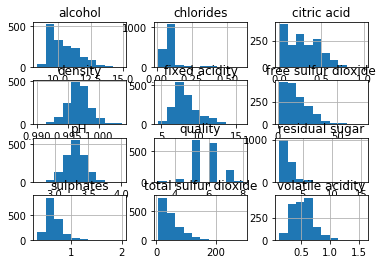

In [8]:
df.hist();

Print the unique class labels (hint: use the `unique` method of pandas Series

In [11]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

#### Split the data into the predicting values X and the class y
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [6]:
X =df.drop('quality',axis=1)

Another quick look to data

In [24]:
print(X.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  


In [7]:
y=df['quality']
y.head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

## Prepare a simple model selection: holdout method
- Split X and y in train and test
- Show the number of samples in train and test, show the number of features

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
print('There are '+str(len(X_train))+' samples in the training dataset')
print('There are '+str(len(X_test))+' samplpes in the testing dataset')
print('Each sample has '+str(X_train.shape[1])+' features')

There are 1199 samples in the training dataset
There are 400 samplpes in the testing dataset
Each sample has 11 features


## Part 1

- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(criterion="entropy")`
- Fit the estimator on the train data and target

In [9]:
estimator = tree.DecisionTreeClassifier(criterion='entropy')
estimator.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Look at the tree structure
- the feature names are used to show the tests in the nodes
    - they are the column names in the X
- the class names 
    - the attribute `estimator.classes_` contains the array of classes detected in the target; if the classes are numbers they have to be transformed in strings with `str()`
- the dept of the visualization can be limited with the parameter `max_depth` 
    
`plt.figure(figsize = (20,20))
 tree.plot_tree(estimator
          , filled=True
          , feature_names = X.columns
          , class_names = str(estimator.classes_)
          , rounded = True
          , proportion = True
          , max_depth = 1
              );`

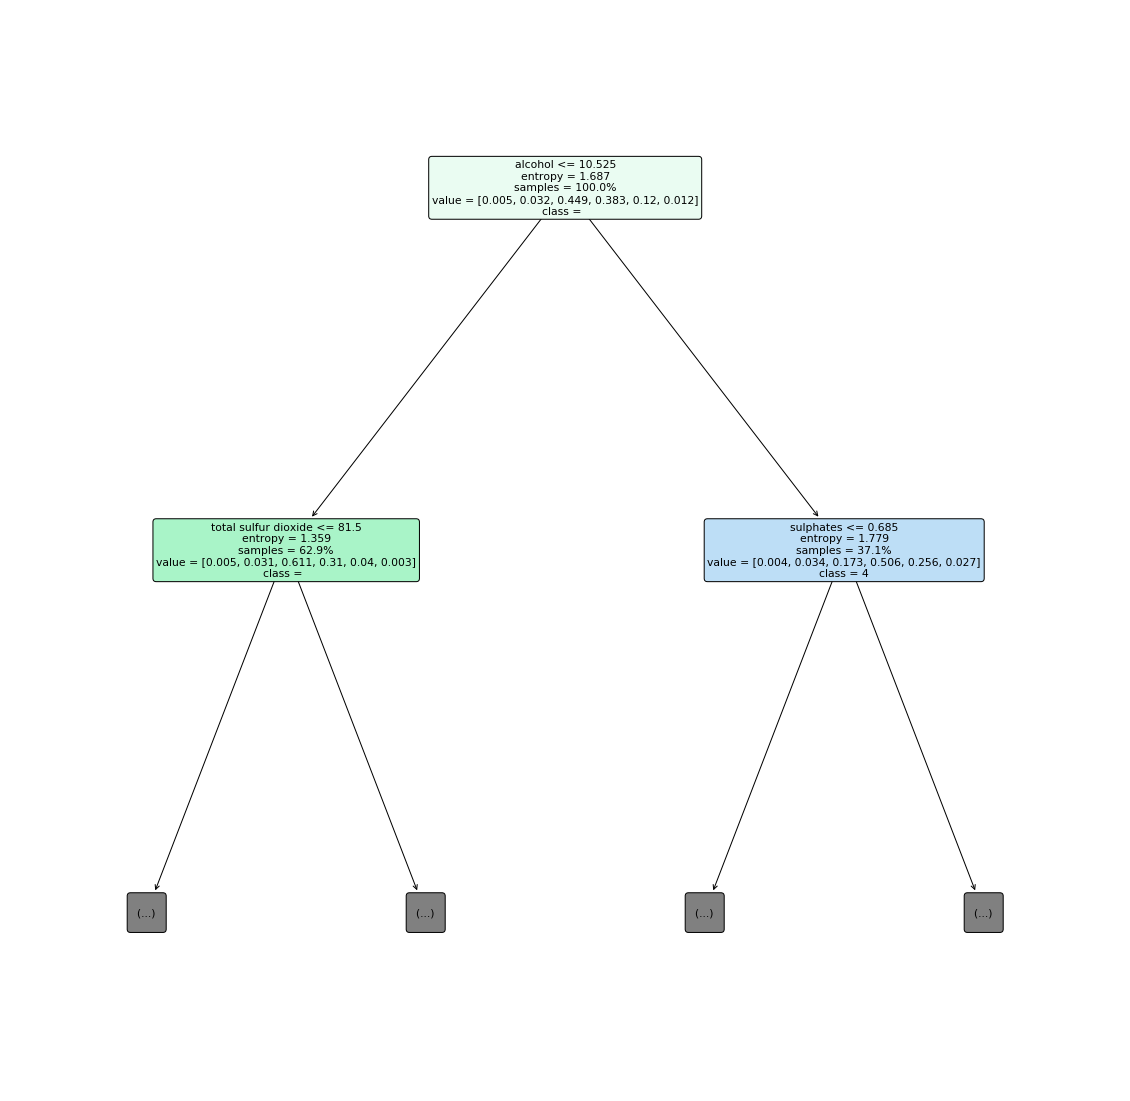

In [10]:
plt.figure(figsize = (20,20))
tree.plot_tree(estimator
          , filled=True
          , feature_names = X.columns
          , class_names = str(estimator.classes_)
          , rounded = True
          , proportion = True
          , max_depth = 1
              );

### Part 1.1

Let's see how it works on training data
- predict the target using the fitted estimator on the training data
- compute the accuracy on the training set using `accuracy_score(<target>,<predicted_target) * 100`

In [11]:
train_pred=estimator.predict(X_train)
print(accuracy_score(train_pred,y_train)*100)

100.0


### Part 1.2

That's more significant: how it works on test data
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [12]:
test_pred = estimator.predict(X_test)
accuracy_test = accuracy_score(test_pred,y_test)*100
print('The accuracy on test set is '+str(accuracy_test))
fitted_max_depth = estimator.tree_.max_depth
parameter_values = range(1,fitted_max_depth+1)
print('The maximum depth of the fitted tree is '+str(fitted_max_depth))

The accuracy on test set is 56.75
The maximum depth of the fitted tree is 17


## Part 2

Optimising the tree: limit the maximum tree depth. We will use the three way splitting: `train, validation, test`. For simplicity, since we already splitted in _train_ and _test_, we will furtherly split the _train_
- split the training set into two parts: __train_t__ and __val__
- max_depth - pruning the tree cutting the branches which exceed max_depth
- the experiment is repeated varying the parameter from 1 to the depth of the unpruned tree
- the scores for the various values are collected and plotted

In [13]:
X_train_t,X_val,y_train_t,y_val = train_test_split(X_train,y_train,test_size=0.25)
print('There are '+str(len(X_train_t))+' in the training dataset')
print('There are '+str(len(X_val))+' in the validation dataset')

There are 899 in the training dataset
There are 300 in the validation dataset


### Loop for computing the score varying the hyperparameter
- initialise a list to contain the scores
- loop varying `par` in `parameter_values`
    - initialize an estimator with a DecisionTreeClassifier, using `par` as maximum depth and `entropy` as criterion
    - fit the estimator on the `train_t` part of the features and the target 
    - predict with the estimator using the validation features
    - compute the score comparing the prediction with the validation target and append it to the end of the list

In [56]:
scores = []
for par in parameter_values:
    estimator = tree.DecisionTreeClassifier(max_depth=par,criterion='entropy')
    Tune_fit=estimator.fit(X_train_t,y_train_t)
    val_pred=estimator.predict(X_val)
    score=accuracy_score(val_pred,y_val)
    scores.append(score)
print(scores)

[0.59, 0.59, 0.5633333333333334, 0.5733333333333334, 0.6, 0.5833333333333334, 0.5266666666666666, 0.5433333333333333, 0.5733333333333334, 0.5866666666666667, 0.6, 0.5633333333333334, 0.5833333333333334, 0.58, 0.5533333333333333, 0.58, 0.5633333333333334]


### Plot the results
Plot using the `parameter_values` and the list of `scores`

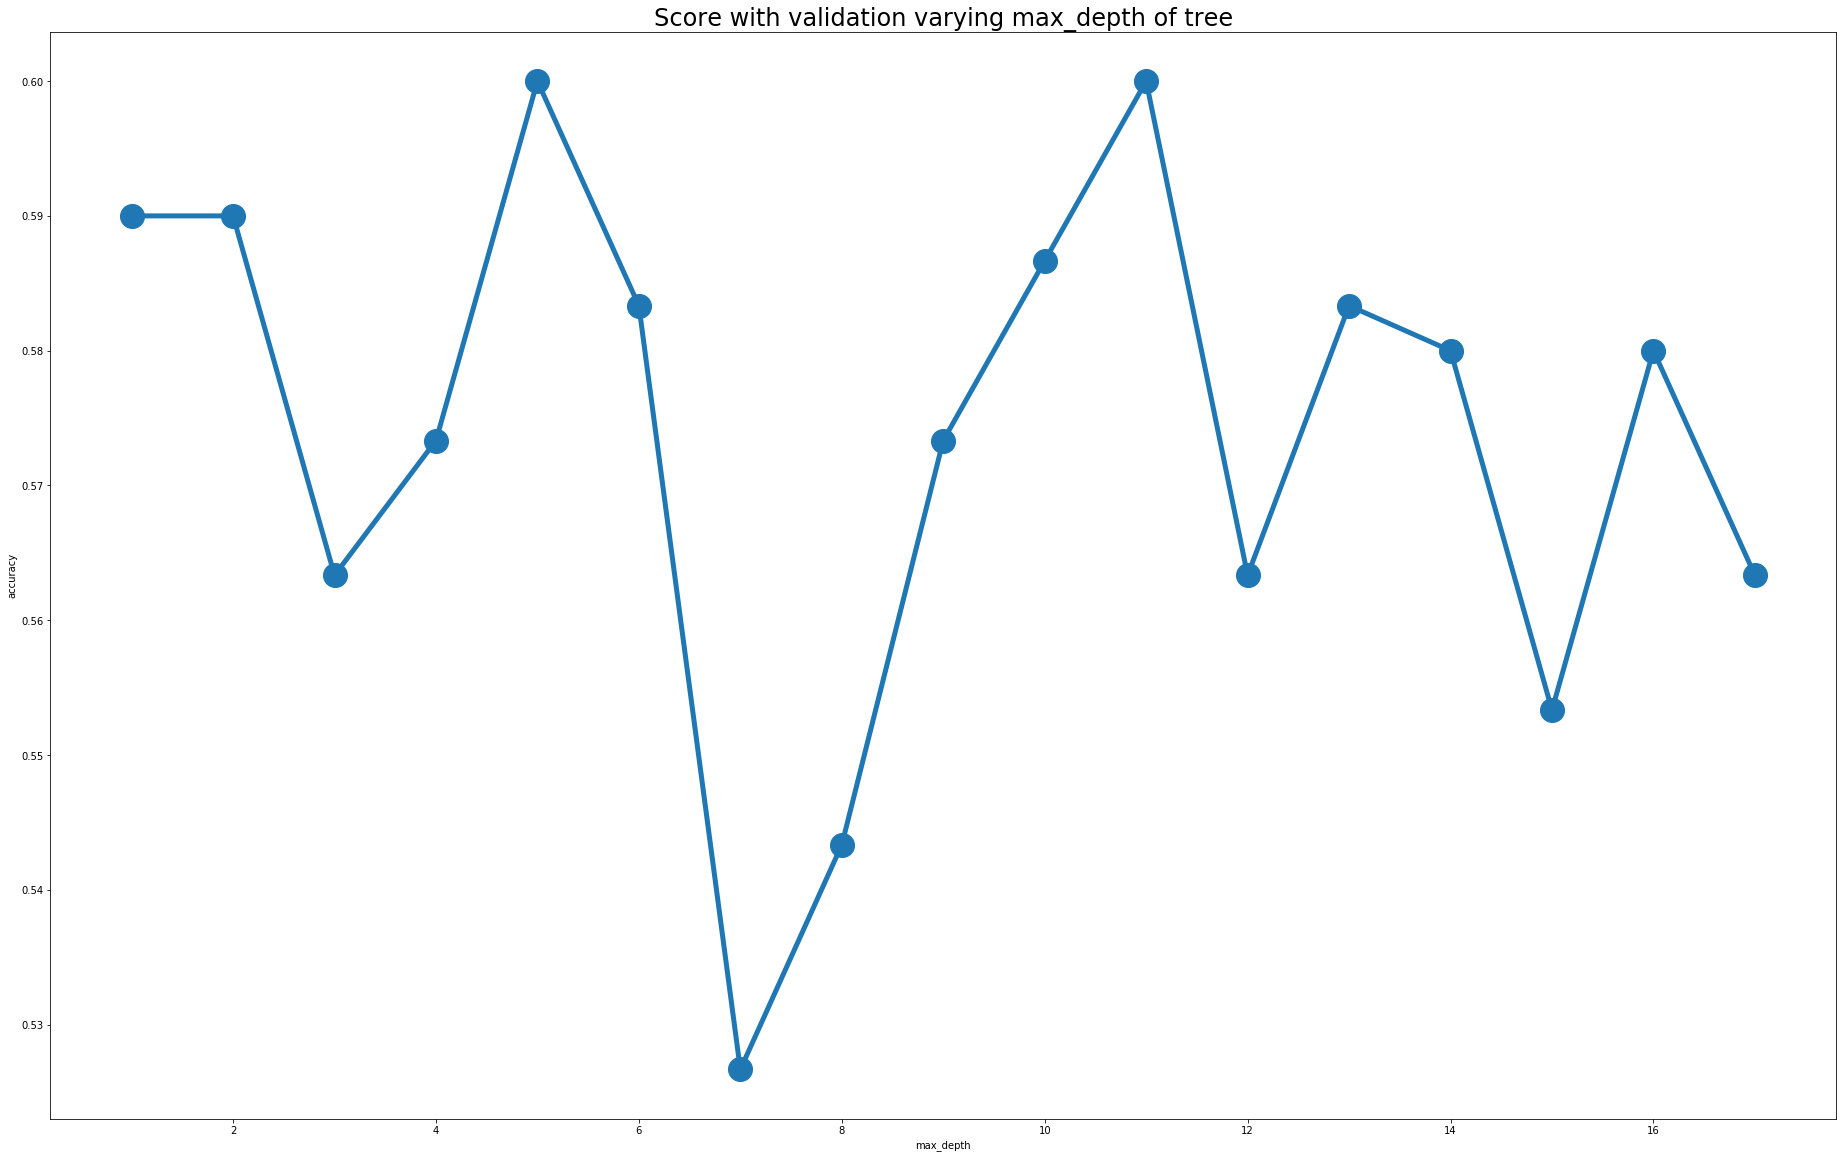

In [59]:
plt.figure(figsize=(32,20))
plt.plot(parameter_values, scores, '-o', linewidth=5, markersize=24)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Score with validation varying max_depth of tree", fontsize = 24)
plt.show();

### Fit the tree after validation and print summary
- store the parameter value giving the best score with `np.argmax(scores)`
- initialize an estimator as a DecisionTreeClassifier, using the best parameter value computed above as maximum depth and `entropy` as criterion
- fit the estimator using the `train` part
- use the fitted estimator to predict using the test features
- compute the accuracy on the test and store it on a variable for the final summary
- print the accuracy on the test set and the best parameter value

In [62]:
par = np.argmax(scores)
print('The top accuracy is '+str(np.max(scores)))
estimator = tree.DecisionTreeClassifier(max_depth=par,criterion='entropy')
estimator.fit(X_train,y_train)
y_pred=estimator.predict(X_test)
final_accuracy=accuracy_score(y_pred,y_test)
print('Obtained with max_depth= '+str(par))

The top accuracy is 0.6
Obtained with max_depth= 4


## Part 3 - Tuning with __Cross Validation__
Optimisation of the hyperparameter with __cross validation__ (cv suffix in the variable names).
Now we will tune the hyperparameter looping on cross validation with the __training set__, then we will fit the estimator on the training set and evaluate the performance on the __test set__

- initialize an empty list for the scores
- loop varying `par` in `parameter_values`
    - initialize an estimator with a DecisionTreeClassifier, using `par` as maximum depth and `entropy` as criterion
    - compute the score using the estimator on the `train` part of the features and the target using 
        - `cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv = 5)`
        - the result is list of scores
    - compute the average of the scores and append it to the end of the list
- print the scores

In [74]:
scores=[]
for par in parameter_values:
    estimator=tree.DecisionTreeClassifier(max_depth=par,criterion='entropy')
    score=cross_val_score(estimator,X_train,y_train,scoring='accuracy',cv=5)
    scores.append(np.mean(score))
print(scores)

[0.5719425034423883, 0.5719425034423883, 0.5576180084623255, 0.5601422717537423, 0.5668169621297057, 0.5694359083490668, 0.5469034704807021, 0.5661134184285413, 0.5669683426303628, 0.569395284978394, 0.595385238301778, 0.578590723318445, 0.5844981362940729, 0.5785670739568766, 0.5794939205885392, 0.5753237093001488, 0.5743925561189177]


Plot using the `parameter_values` and the list of `scores`

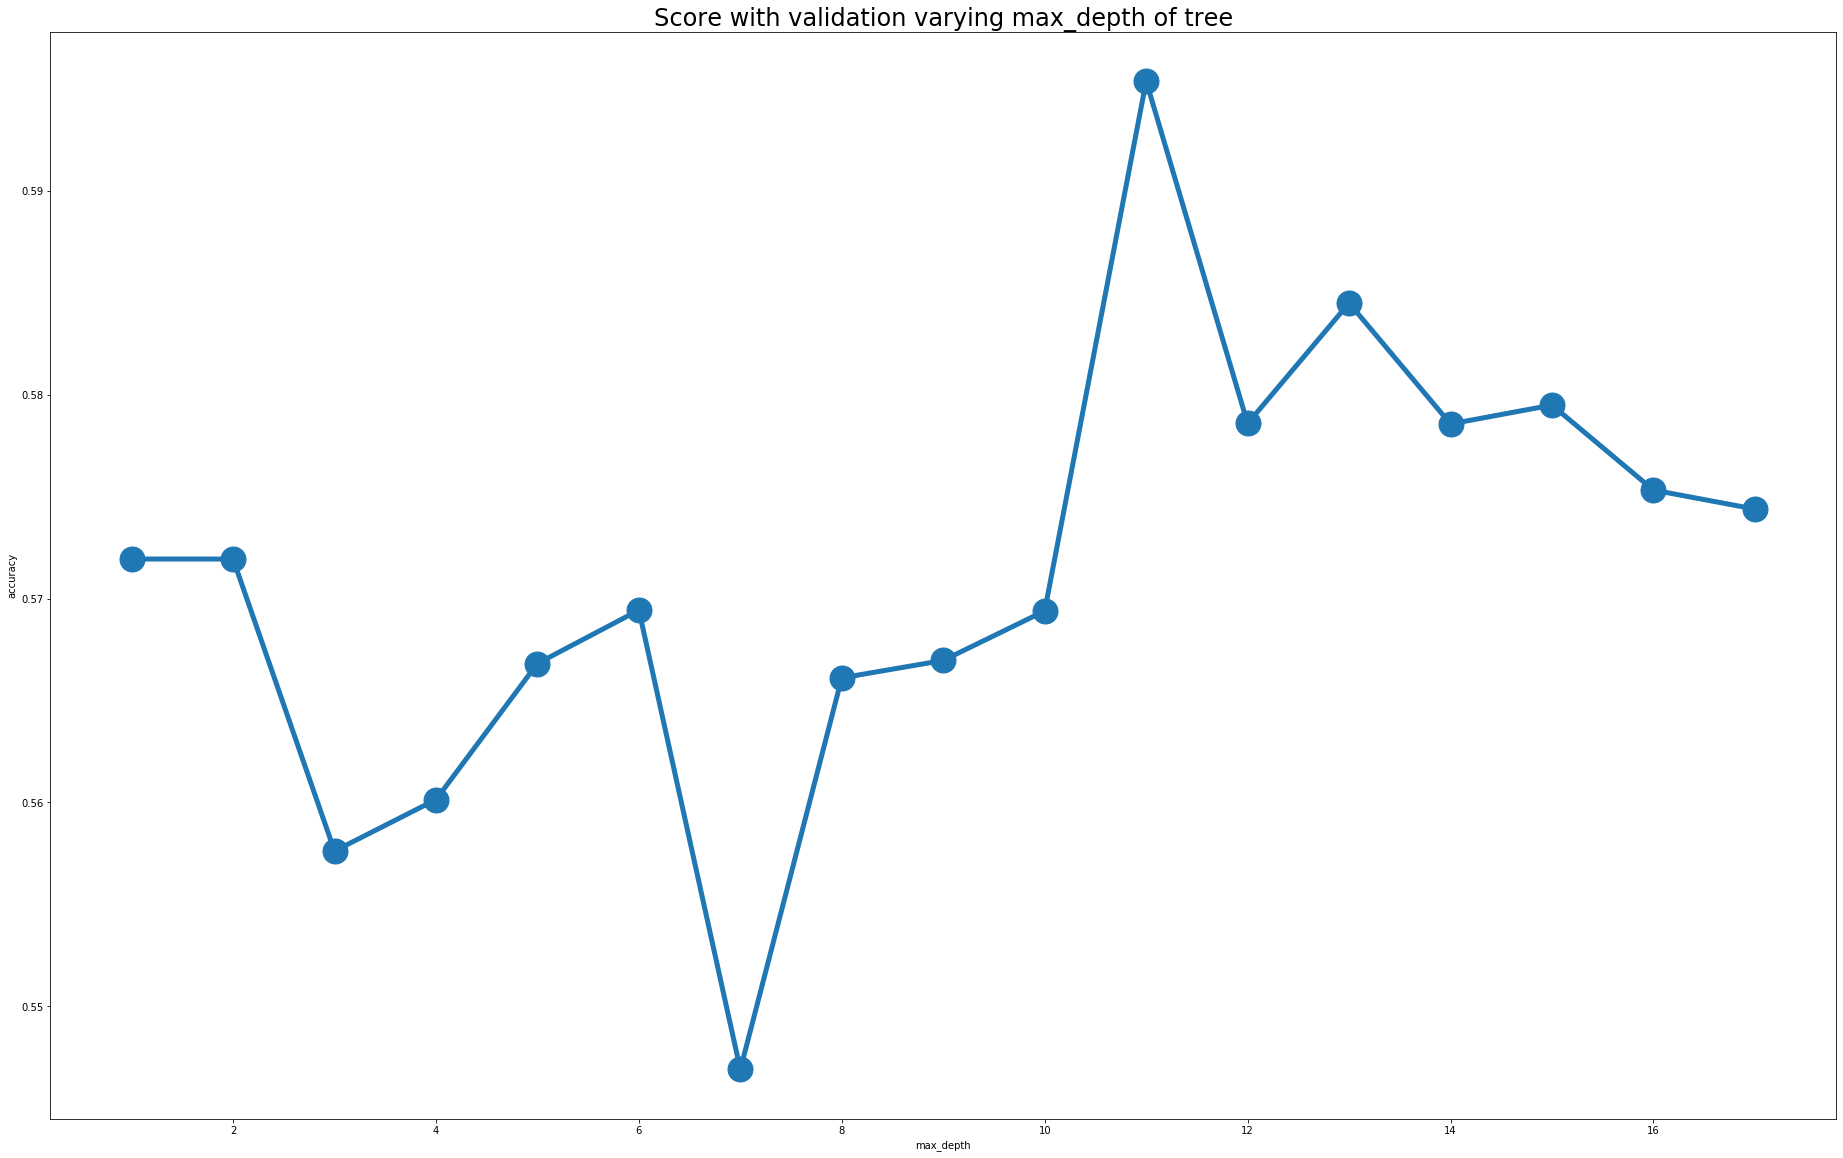

In [75]:
plt.figure(figsize=(32,20))
plt.plot(parameter_values,scores,'-o',linewidth=5,markersize=25)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Score with validation varying max_depth of tree", fontsize = 24)
plt.show();

### Fit the tree after cross validation and print summary
- store the parameter value giving the best score with `np.argmax(scores)`
- initialize an estimator as a DecisionTreeClassifier, using the best parameter value computed above as maximum depth and `entropy` as criterion
- fit the estimator using the `train` part
- use the fitted estimator to predict using the test features
- compute the accuracy on the test and store it on a variable for the final summary
- print the accuracy on the test set and the best parameter value

In [76]:
par = np.argmax(scores)
estimator=tree.DecisionTreeClassifier(max_depth=par,criterion='entropy')
estimator.fit(X_train,y_train)
y_predicted=estimator.predict(X_test)
accuracy_final = accuracy_score(y_predicted,y_test)
print('The accuracy on test set tuned with cross_validation is '+str(accuracy_final)+' with depth '+str(par))

The accuracy on test set tuned with cross_validation is 0.565 with depth 10


`print(classification_report(y_test, y_predicted))`

In [77]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           3       0.20      0.25      0.22         4
           4       0.08      0.07      0.07        15
           5       0.59      0.73      0.65       143
           6       0.64      0.53      0.58       179
           7       0.47      0.45      0.46        55
           8       0.00      0.00      0.00         4

    accuracy                           0.56       400
   macro avg       0.33      0.34      0.33       400
weighted avg       0.57      0.56      0.56       400



- **micro**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.
- **macro**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- **weighted**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.


In [78]:
print(confusion_matrix(y_test, y_predicted))

[[  1   1   1   0   1   0]
 [  3   1   7   3   1   0]
 [  1   6 104  29   2   1]
 [  0   4  55  95  23   2]
 [  0   1   7  20  25   2]
 [  0   0   2   1   1   0]]


# 4. Tuning with an ensemble method
We will use the [__bagging__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) method, made available by `scikit-learn`, for documentation see the pdf file provided, or the online documentation.
- initialize an empty list for the scores
- loop varying `par` in `parameter_values`
    - initialize an estimator with a BaggingClassifier applied to a DecisionTreeClassifier, using `par` as maximum depth and `entropy` as criterion (see below the statement)
    - fit the estimator on the `train` part
    - compute the score using the `score` method of the estimator on the `train` part of the features and the target, append the score to the end of the list
- print the scores

`estimator_bagging = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth = par)
                                     , max_samples=0.5, max_features=0.5)`

In [82]:
scores = []
#scores2 = []
for par in parameter_values:
    
#    estimator_bagging = tree.DecisionTreeClassifier(criterion="entropy", max_depth = par)
    estimator_bagging = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth = par)
                                     , max_samples=0.5, max_features=0.5)
    estimator_fit = estimator_bagging.fit(X_train,y_train)
    y_pred = estimator_bagging.predict(X_train)
#    y_pred_test = estimator_bagging.predict(X_test)
    score = accuracy_score(y_pred,y_train)
#    score_test = accuracy_score(y_pred_test,y_test)
    scores.append(score)
#    scores2.append(score_test)
print(scores)
#print(scores2)

[0.572977481234362, 0.6005004170141784, 0.6088407005838199, 0.6346955796497081, 0.6980817347789825, 0.7239366138448707, 0.7689741451209341, 0.8290241868223519, 0.8623853211009175, 0.8748957464553795, 0.8798999165971643, 0.8974145120934112, 0.9107589658048374, 0.9090909090909091, 0.9040867389491243, 0.9015846538782318, 0.9132610508757297]



Plot the scores, as done in the previous cases

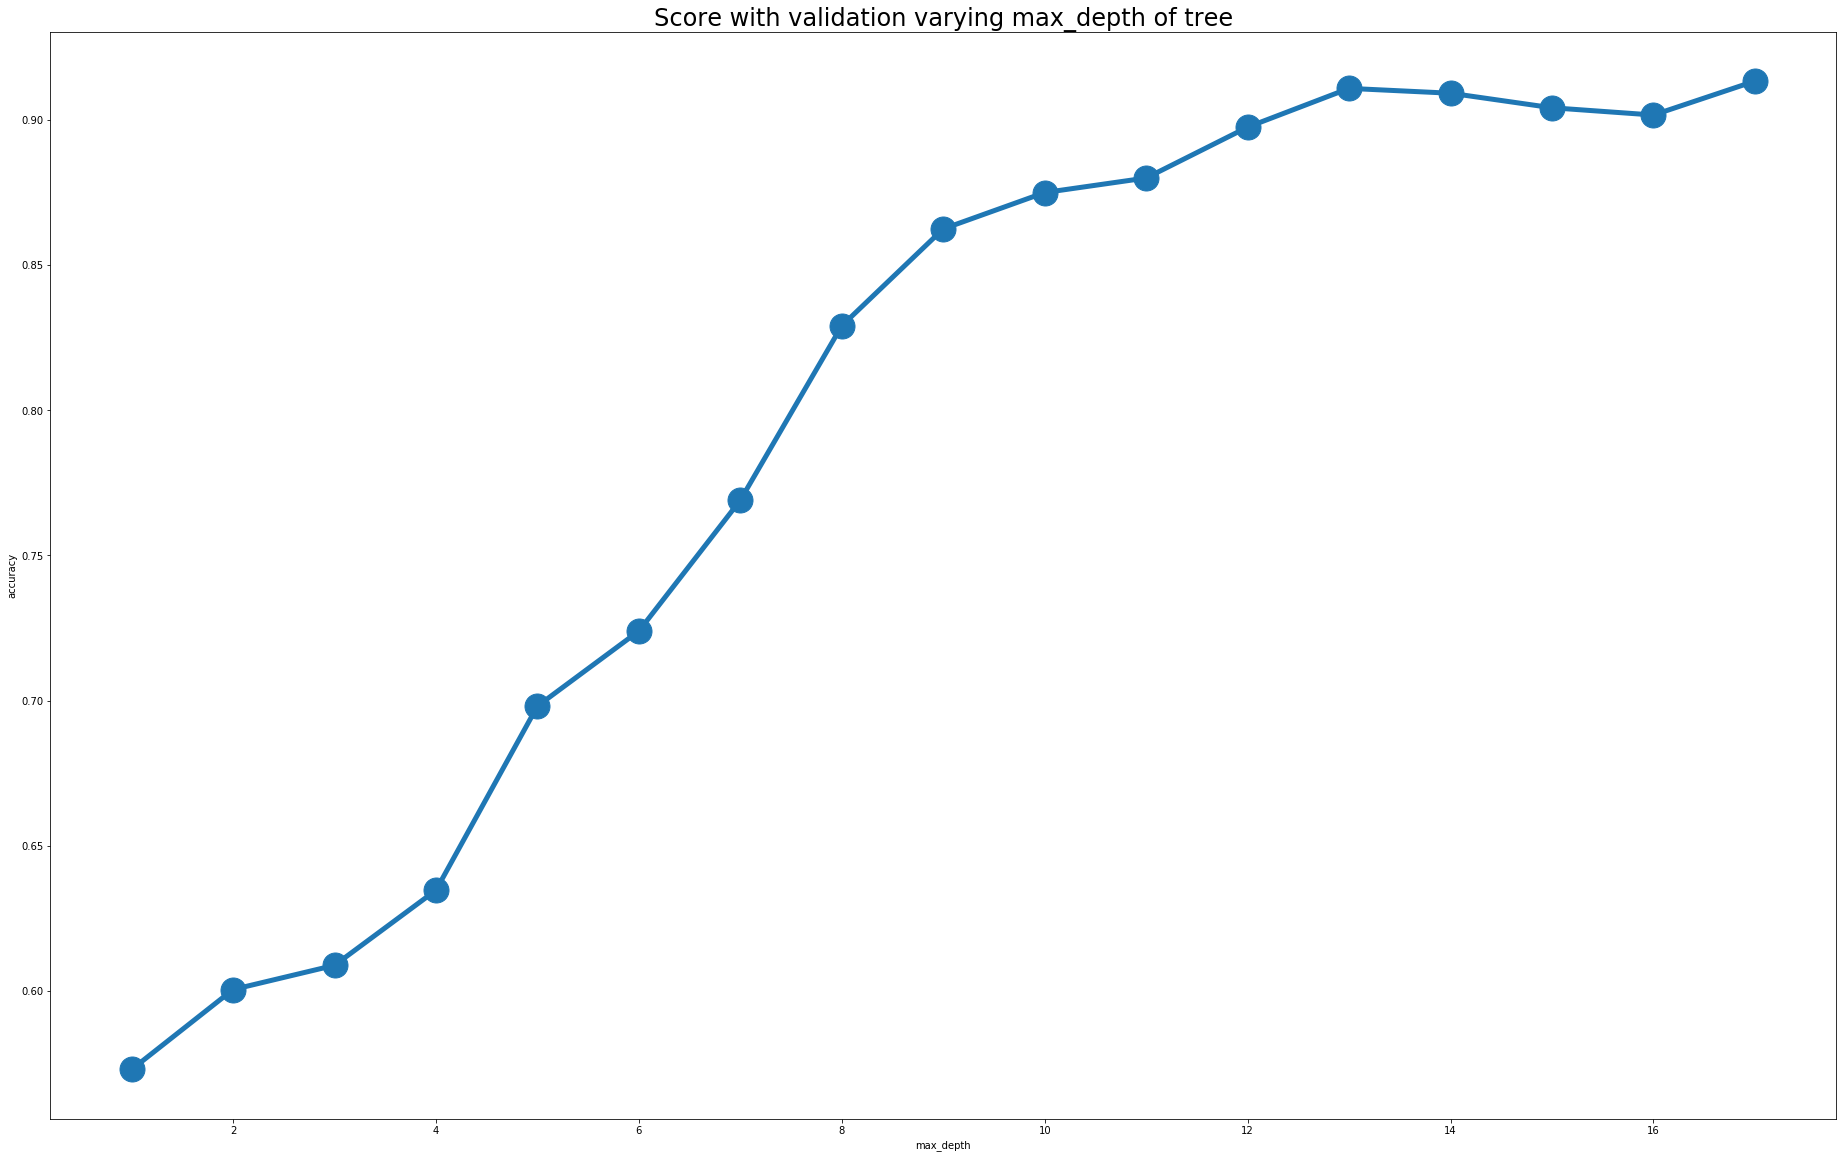

In [83]:
plt.figure(figsize=(32,20))
plt.plot(parameter_values,scores,'-o',linewidth=5,markersize=25)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Score with validation varying max_depth of tree", fontsize = 24)
plt.show();

### Fit the tree after bagging and print summary
- store the parameter value giving the best score with `np.argmax(scores)`
- initialize an estimator as above, using the best parameter value computed above as maximum depth and `entropy` as criterion
- fit the estimator using the `train` part
- use the fitted estimator to predict using the test features
- compute the accuracy on the test and store it on a variable for the final summary
- print the accuracy on the test set and the best parameter value

In [84]:
par = np.argmax(scores)
estimator_bagging = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth = par)
                                     , max_samples=0.5, max_features=0.5)
estimator_bagging.fit(X_train,y_train)
y_pred = estimator_bagging.predict(X_test)
test_accuracy = accuracy_score(y_pred,y_test)
print('accuracy of the test set is '+str(test_accuracy)+' at maximum depth '+str(par))

accuracy of the test set is 0.56 at maximum depth 16


Print a summary of the four experiments

In [ ]:
Observations made from the above four experiments:
1) By looking at the difference between the accuracies of train at first  and test data later
2) accuracy of train data reaches to almost 100% which represents the no bias
3) accuracy of test data also varies a lot of difference from the accurancy of train data which represents the high variance
4) In machine learning language , a model which is in above two points situation means, model is overfitted
6) check out the by enabling the bagging classifier in the command line.,
5) Now, i could see the improvement in the bias by looking at accuracy of train data and reduction of the varaince 

In [85]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


### Suggested exercises
- try other datasets
- try to optimise the parameters "min_impurity_decrease" "min_samples_leaf" and "min_samples_split"